In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pytransit import QuadraticModel
from decimal import Decimal
import emcee
import corner
from IPython.display import display, Math
import csv 
from numpy import savetxt
from numpy import loadtxt
from numpy import random
from multiprocessing import Pool
from transitleastsquares import transitleastsquares
import batman
import statistics
from statistics import mode
import pandas as pd
from tabulate import tabulate

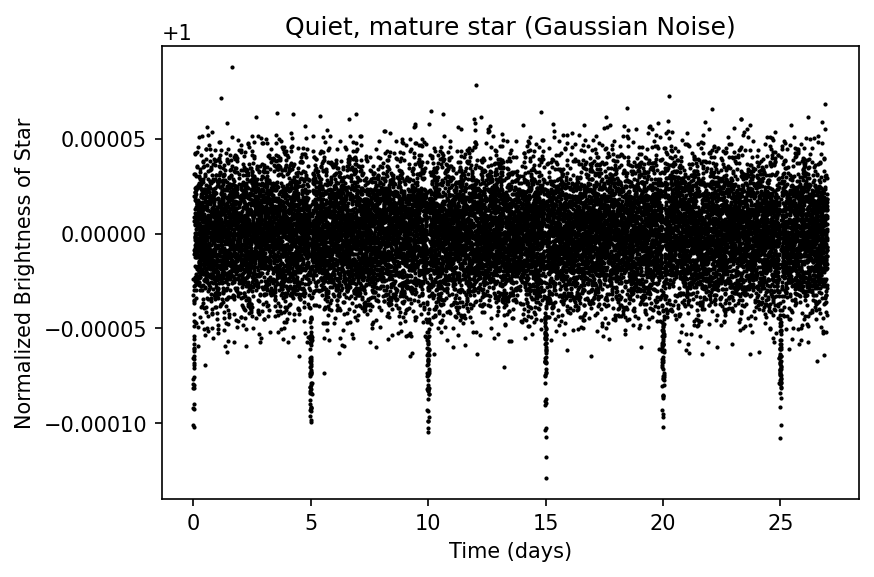

In [6]:
#Enter parameters
period = 5.
rp_over_rstar = .008
a_over_rstar = 19.53338
inc = 90.
error_amount = .2 * 10 ** (-4) #per point error this s the transit depth of the earth around the star

params = [period, rp_over_rstar, a_over_rstar, inc]

#gaussian noise array
flux_err = np.array([])
for timestep in range(1,19441):
    noise = random.normal(0,error_amount)
    flux_err = np.append(flux_err, noise)

#time array
time = np.linspace(0,27,19441)


#Batman
from matplotlib import rcParams; rcParams["figure.dpi"] = 150

# Create test data
time_start = 0
data_duration = 27
samples_per_day = 720
samples = int(data_duration * samples_per_day)
time = np.linspace(time_start, time_start + data_duration, samples)

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
ma.per = period  # orbital period
ma.rp = rp_over_rstar  # 6371 planet radius (in units of stellar radii)
ma.a = a_over_rstar  # semi-major axis (in units of stellar radii)
ma.inc = inc  # orbital inclination (in degrees)
ma.ecc = 0.  # eccentricity
ma.w = 0.  # longitude of periastron (in degrees)
ma.u = [0.0, 0.0]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = batman.TransitModel(ma, time)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

# Create noise and merge with flux

flux = synthetic_signal + flux_err

# Plot Batman flux array (points)
plt.figure()
ax = plt.gca()
ax.scatter(time, flux, color='black', s=1)
plt.title('Quiet, mature star (Gaussian Noise)')
ax.set_ylabel("Normalized Brightness of Star")
ax.set_xlabel("Time (days)")


#pytransit
def model(time,period,rp_over_rstar,a_over_rstar,inc):
    """
    Function for computing transit models for the set of 8 free paramters
    x - time array
    """
    tm = QuadraticModel()
    tm.set_data(time)
    i=inc/180.0*np.pi
    #w=omega/180.0*np.pi
    lightcurve=tm.evaluate(k=rp_over_rstar, ldc=[0.0,0.0], t0=0.0, p=period, a=a_over_rstar, i=i)
    return lightcurve

# Plot pytransit flux array (blue lines)
#flux=model(time,period,rp_over_rstar,a_over_rstar,inc) #for a star with half radius and half mass of sun

#lc_w_noise = flux + flux_err

#plt.plot(time, lc_w_noise)


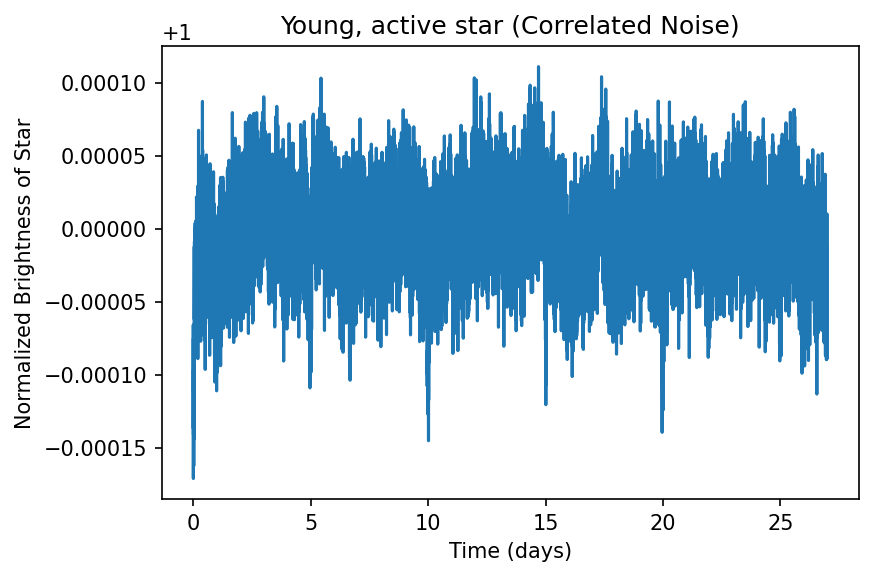

In [10]:
#Make colored Noise
from stochastic.processes.base import BaseTimeProcess
from stochastic.utils.validation import check_numeric
from stochastic.utils.validation import check_positive_integer
from stochastic.processes.noise import ColoredNoise
from stochastic.processes.noise import GaussianNoise

colored_noise = ColoredNoise(beta=1,t=27, rng=None) #t is right hand endpoint, -1=blue 2=red 1=pink -2=violet 0=white


cmag = error_amount /.007 #i believe the error is automatically at .007 compared to my error function, just from eyeballing
cnoise = colored_noise.sample(19439)
flux_err = cnoise * cmag


lc_w_noise = flux_err + flux ##SETTING NEW VALUES FOR FLUX ERROR, FLUX IS THE SAME THOUGH

plt.title('Young, active star (Correlated Noise)')
plt.ylabel("Normalized Brightness of Star")
plt.xlabel("Time (days)")
plt.plot(time, lc_w_noise)
plt.show()

## stochastic gauss vs my gauss
# gauss = GaussianNoise(t=1, rng=None)
# s = gauss.sample(19440)
# gauss_flux = s + flux
# times = gauss.times(19439)


# plt.plot(times, gauss_flux)
# plt.show()

# plt.plot(time, lc_w_noise)

Text(0.5, 0, 'Time (days)')

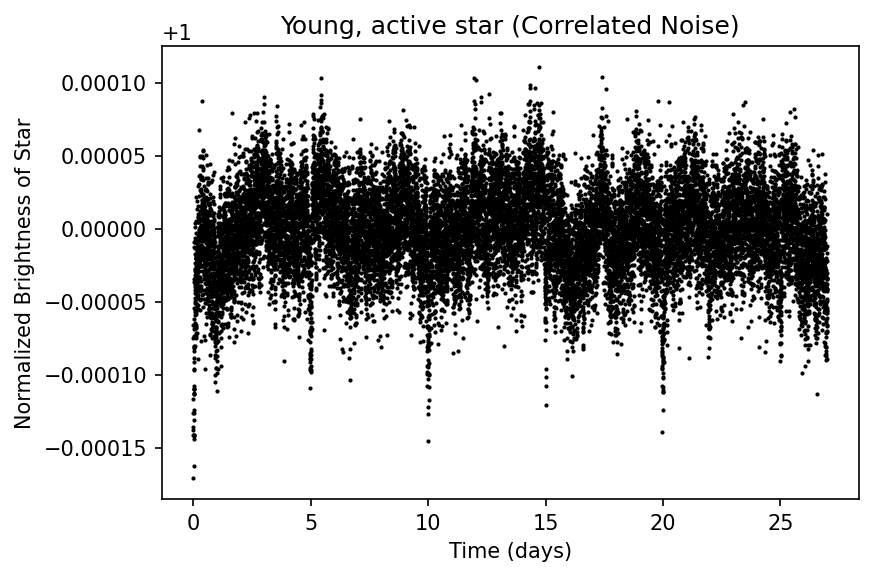

In [12]:
plt.figure()
ax = plt.gca()
ax.scatter(time, lc_w_noise, color='black', s=1)
plt.title('Young, active star (Correlated Noise)')
ax.set_ylabel("Normalized Brightness of Star")
ax.set_xlabel("Time (days)")

In [6]:
# #Binning the data
# #No need to alter anything in this cell
# #This function bins the data, in order to save processing time during the transitleastsquares fit
# def rebin(nbin,time,flux):
#     start_interval=time[1]-time[0]
#     bin_interval=(start_interval)*nbin
#     flux_bin=[]
#     time_bin=[]
#     err_bin=[]
#     tmax=np.min(time)
#     i=0
#     while tmax<np.max(time):
#         bincenter=np.min(time)+(i+0.5)*bin_interval
#         index=np.where(np.abs(time-bincenter) < bin_interval/2.0)
#         if len(time[index]):
#             flux_bin=np.append(flux_bin,np.mean(flux[index]))
#             time_bin=np.append(time_bin,np.mean(time[index]))
#             err_bin=np.append(err_bin,np.std(flux[index])) 
#             tmax=np.max(time[index])        
#         i=i+1

#     return time_bin,flux_bin,err_bin
        
# #This bins to roughly one point every 5 minutes, though you can try different bins if you like!
# time_bin,flux_bin,err_bin=rebin(3,time,lc_w_noise)

# here=np.where(err_bin > 0)
# time_bin=time_bin[here]
# flux_bin=flux_bin[here]
# err_bin=err_bin[here]

# #plt.title("Binned flux") #plot binned flux
# #plt.plot(time_bin,flux_bin)

In [7]:
# Running transit least squares
leastsquares = transitleastsquares(time, lc_w_noise)#binned:(time_bin, flux_bin) #unbinned: (time, lc_w_noise)
results = leastsquares.power()

Transit Least Squares TLS 1.0.26 (20 March 2021)


/Users/danayaptangco/opt/anaconda3/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)
  0%|          | 0/2458 periods | 00:00<?

Creating model cache for 38 durations
Searching 19439 data points, 2458 periods from 0.602 to 13.499 days
Using all 4 CPU threads


 95%|█████████▌| 2345/2458 periods | 03:16<00:06

KeyboardInterrupt: 

12.103599636188338
0.037935174


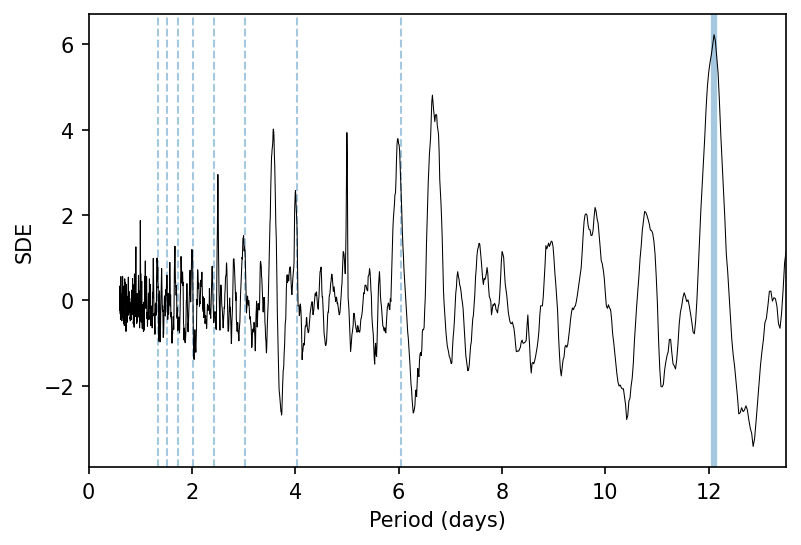

In [25]:
# Showing the batman plot

plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))

print(results.period)
print(results.FAP) #if greater than 10^(-4)


#use the index to find x value at max y value

# plt.figure()
# plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
# plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
# plt.xlim(0.48, 0.52)
# plt.ticklabel_format(useOffset=False)
# plt.xlabel('Phase')
# plt.ylabel('Relative flux');

0.9619570769117002
Guess values: 
4.997215552992958 0.19504595122252555 19.534994607843554 90.0


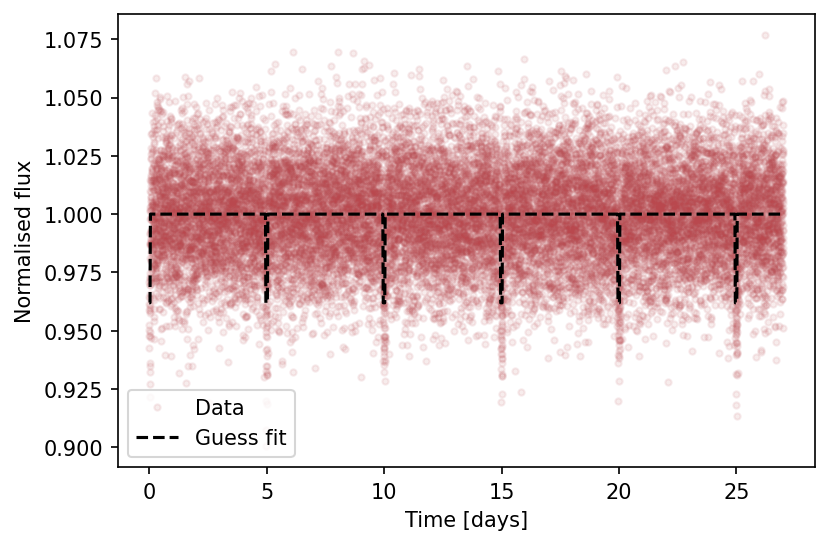

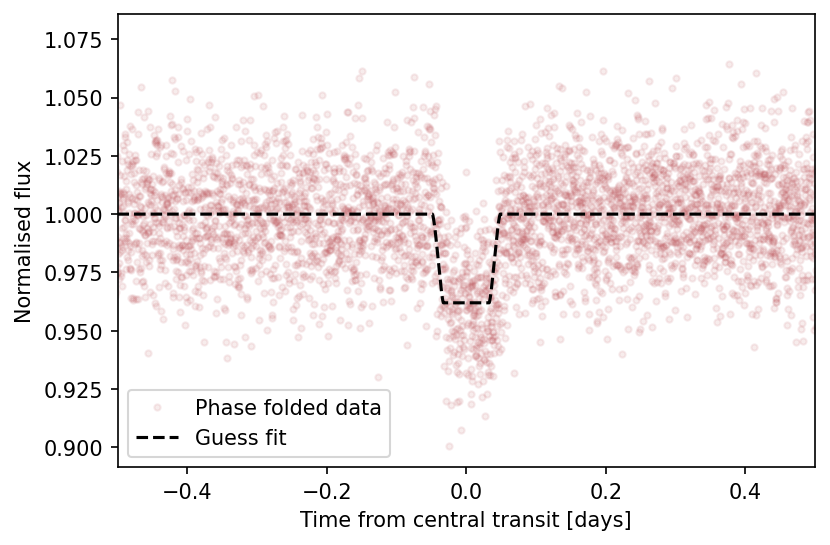

In [34]:
#HERE IS WHERE YOU ENTER YOUR GUESSES
r_star = 0.002325235 #half radius of the sun in AU
p_years = results.period / 365
guess_au = ((p_years ** 2) / 2) ** (1/3)

period_in_mins = results.period * 1440
transit_dur_days = ((2 * np.pi * guess_au)/results.period) / (r_star * 2)
transit_dur_mins = transit_dur_days * 1440



transit_1 = lc_w_noise[0:30]  # goal is to use estimated period by batman and aonr formula to auto do this
transit_2 = lc_w_noise[7170:7230]
transit_3 = lc_w_noise[14370:14430]
transit_4 = lc_w_noise[21570:21630]
transit_5 = lc_w_noise[28770:28830]
transit_6 = lc_w_noise[35970:36030]
flux_in_transit = []
flux_in_transit.extend(transit_1)
flux_in_transit.extend(transit_2)
flux_in_transit.extend(transit_3)
flux_in_transit.extend(transit_4)
flux_in_transit.extend(transit_5)
flux_in_transit.extend(transit_6)

depth_average = sum(flux_in_transit) / len(flux_in_transit)
print(depth_average)


guess_period = results.period
guess_ronr = (1- depth_average) ** (1/2)
guess_aonr = guess_au / r_star
guess_inc = 90. #not calculated rn



print("Guess values: ")
print(results.period, guess_ronr, guess_aonr, guess_inc)
#guess_period=params[0]
#guess_ronr=params[1]
#guess_aonr=params[2]
#guess_inc=params[3]
#guess_ecc=params[4]
#guess_omega=params[5]

#Don't need to alter below here in this cell-------
guess=[guess_period, guess_ronr, guess_aonr, guess_inc]

## Phasefold data time-array
phase = (time) % guess[0] / guess[0]
phase[np.where(phase>0.5)] -= 1 
sorted = np.argsort(phase)

plt.plot(time,lc_w_noise,".", color='xkcd:dusty red', label='Data', alpha=0.1)
guess_lightcurve=model(time,*guess)
plt.plot(time,guess_lightcurve,'--k', label='Guess fit')
plt.legend(loc="lower left")
plt.ylabel("Normalised flux")
plt.xlabel("Time [days]")
plt.show()

## Plot data & model together, phase fold
plt.plot(phase*guess[0], lc_w_noise, ".", color='xkcd:dusty red', label='Phase folded data', alpha=0.1)
plt.plot(phase[sorted]*guess[0], guess_lightcurve[sorted], '--k', label='Guess fit')
plt.legend(loc="lower left")
plt.xlim(-0.5, 0.5)
plt.xlabel("Time from central transit [days]")
plt.ylabel("Normalised flux")

plt.show()

In [35]:
#How much can the MCMC stray from the original guesses? 
priors = [guess_period*0.9, guess_period*1.1,
          guess_ronr*0.5,guess_ronr*1.5,
         guess_aonr*0.3,guess_aonr*3.0,0,90]

#This function calculates the ``goodness of fit" of the model, using chi-squared
def log_likelihood(theta, time, flux, flux_err):
#     t0, per, rp, a, inc, ecc, w, baseline = theta
    model_lightcurve = model(time, *theta)
    sigma2 = flux_err ** 2 
    return -0.5 * np.sum((flux - model_lightcurve) ** 2 / sigma2 + np.log(2. * np.pi*sigma2))

#This function tells the code to spit the guess back if it wanders outside the acceptable range 
def log_prior(theta):
    # The parameters are stored as a vector of values, so unpack them
    per, rp, a, inc = theta
    # We're using only uniform priors:
    if priors[0] > per or per > priors[1]:
        return -np.inf
    if priors[2] > rp or rp > priors[3]:
        return -np.inf
    if priors[4] > a or a > priors[5]:
        return -np.inf
    if priors[6] > inc or inc > priors[7]:
        return -np.inf
    return 0.0

## The full log-probability function is:
def log_probability(theta, time, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    #print(log_likelihood(theta, time, flux, flux_err))
    return lp + log_likelihood(theta, time, flux, flux_err)

In [36]:
#This one may take a while to run!
#We have six dimensions, for each of the parameters we're fitting!
ndim = 4
nwalkers = ndim*2  # Number of walkers. It is recommended to be at least higher than twice 
                   # the amount of parameters being fit

# theta = [period, rp/Rstar, a/Rstar, inc, ecc, omega]
#How close to the original guess should I start exploring, for each parameter?
order_of_mag = np.array([1e-3, 1e-3, 0.5, 1e-3])

pos = guess+ order_of_mag * np.random.randn(nwalkers, ndim)

print(pos[0,:])


[ 4.99915564  0.1944787  19.92317855 90.00154285]


In [37]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_err))# flux, flux_err
sampler.run_mcmc(pos, 10000, progress=True)

#If your computer has multiprocessing capabilities, you can comment out the lines below instead of 
#using the two lines of code immediately above this. It will go faster!
#with Pool() as pool:
 #   sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_bin, flux_bin, err_bin),pool=pool)
 #   sampler.run_mcmc(pos, 10000, progress=True)


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/danayaptangco/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]

  3%|▎         | 304/10000 [00:44<28:05,  5.75it/s]


  7%|▋         | 700/10000 [01:33<16:06,  9.63it/s]


 11%|█         | 1112/10000 [24:29<14:31, 10.20it/s]


 16%|█▌        | 1565/10000 [25:19<20:27,  6.87it/s]


 21%|██        | 2096/10000 [26:08<11:13, 11.74it/s]


 25%|██▍       | 2463/10000 [26:56<19:42,  6.37it/s]


 28%|██▊       | 2785/10000 [27:48<18:22,  6.54it/s]


 32%|███▏      | 3216/10000 [28:37<10:24, 10.86it/s]


 38%|███▊      | 3800/10000 [29:27<08:20, 12.38it/s]


 44%|████▍     | 4384/10000 [30:15<07:26, 12.59it/s]


 50%|████▉     | 4968/10000 [31:04<06:33, 12.80it/s]


 56%|█████▌    | 5551/10000 [31:54<07:01, 10.56it/s]


 60%|█████▉    | 5959/10000 [32:47<06:42, 10.05it/s]


 63%|██████▎   | 6320/10000 [33:49<10:33,  5.81it/s]


 68%|██████▊   | 6770/10000 [34:37<05:12, 10.35it/s]


 72%|███████▏  | 7202/10000 [35:26<07:14,  6.44it/s]


 76%|███████▋  | 7637/10000 [36:14<03:49, 10.31it/s]


 81%|████████  | 8095/10000 [37:02<04:57,  6.40it/s]


 85%|████████▌ | 8524/10000 [37:50<02:08, 11.50it/s]


 90%|█████████ | 9011/10000 [38:39<02:16,  7.26it/s]


 94%|█████████▍| 9446/10000 [39:29<01:10,  7.86it/s]


 99%|█████████▉| 9899/10000 [40:15<00:09, 10.53it/s]


100%|██████████| 10000/10000 [40:28<00:00,  4.12it/s]


State([[ 5.00000276  0.20006678 19.4948645  89.79959358]
 [ 5.00001129  0.19979279 19.54074477 89.95888085]
 [ 4.9999975   0.20017705 19.49237942 89.79821514]
 [ 5.00001182  0.20006347 19.37990113 89.59172685]
 [ 4.99999288  0.2000181  19.53184233 89.93617968]
 [ 4.99998775  0.20012184 19.48646687 89.81823447]
 [ 5.0000119   0.19973143 19.51764602 89.85660936]
 [ 5.00000002  0.19998102 19.50698416 89.84266768]], log_prob=[70573.54462311 70570.55234566 70572.70511089 70569.86339829
 70572.90253273 70571.16094307 70569.68704475 70573.76467853], blobs=None, random_state=('MT19937', array([4067518323, 2626379534, 1023083740, 1988732404, 2514644866,
       4204802332, 3438301138, 1097962882,  334804930, 2299156100,
       3000502506, 3809151296,  559532942, 2365768833, 1333159501,
       3790860933, 1692548752, 3697182035, 3968504786, 1612751479,
       2853557165, 1731529353, 3789717814, 1035927824, 1728112084,
       3743049373,  381935948, 2001011047, 1838509491,  411016197,
       35442

In [38]:
flat_samples = sampler.get_chain(discard=200, thin=5, flat=True)
#flat_samples = loadtxt('MCMC_samples.csv', delimiter=',')
log_prob = sampler.get_log_prob(discard=200, thin=5, flat=True)

#This line saves your MCMC samples, since the cell above may have taken a long time to run!
savetxt('MCMC_samples.csv', flat_samples, delimiter=',')
savetxt('log_prob_samples.csv', log_prob, delimiter=',')


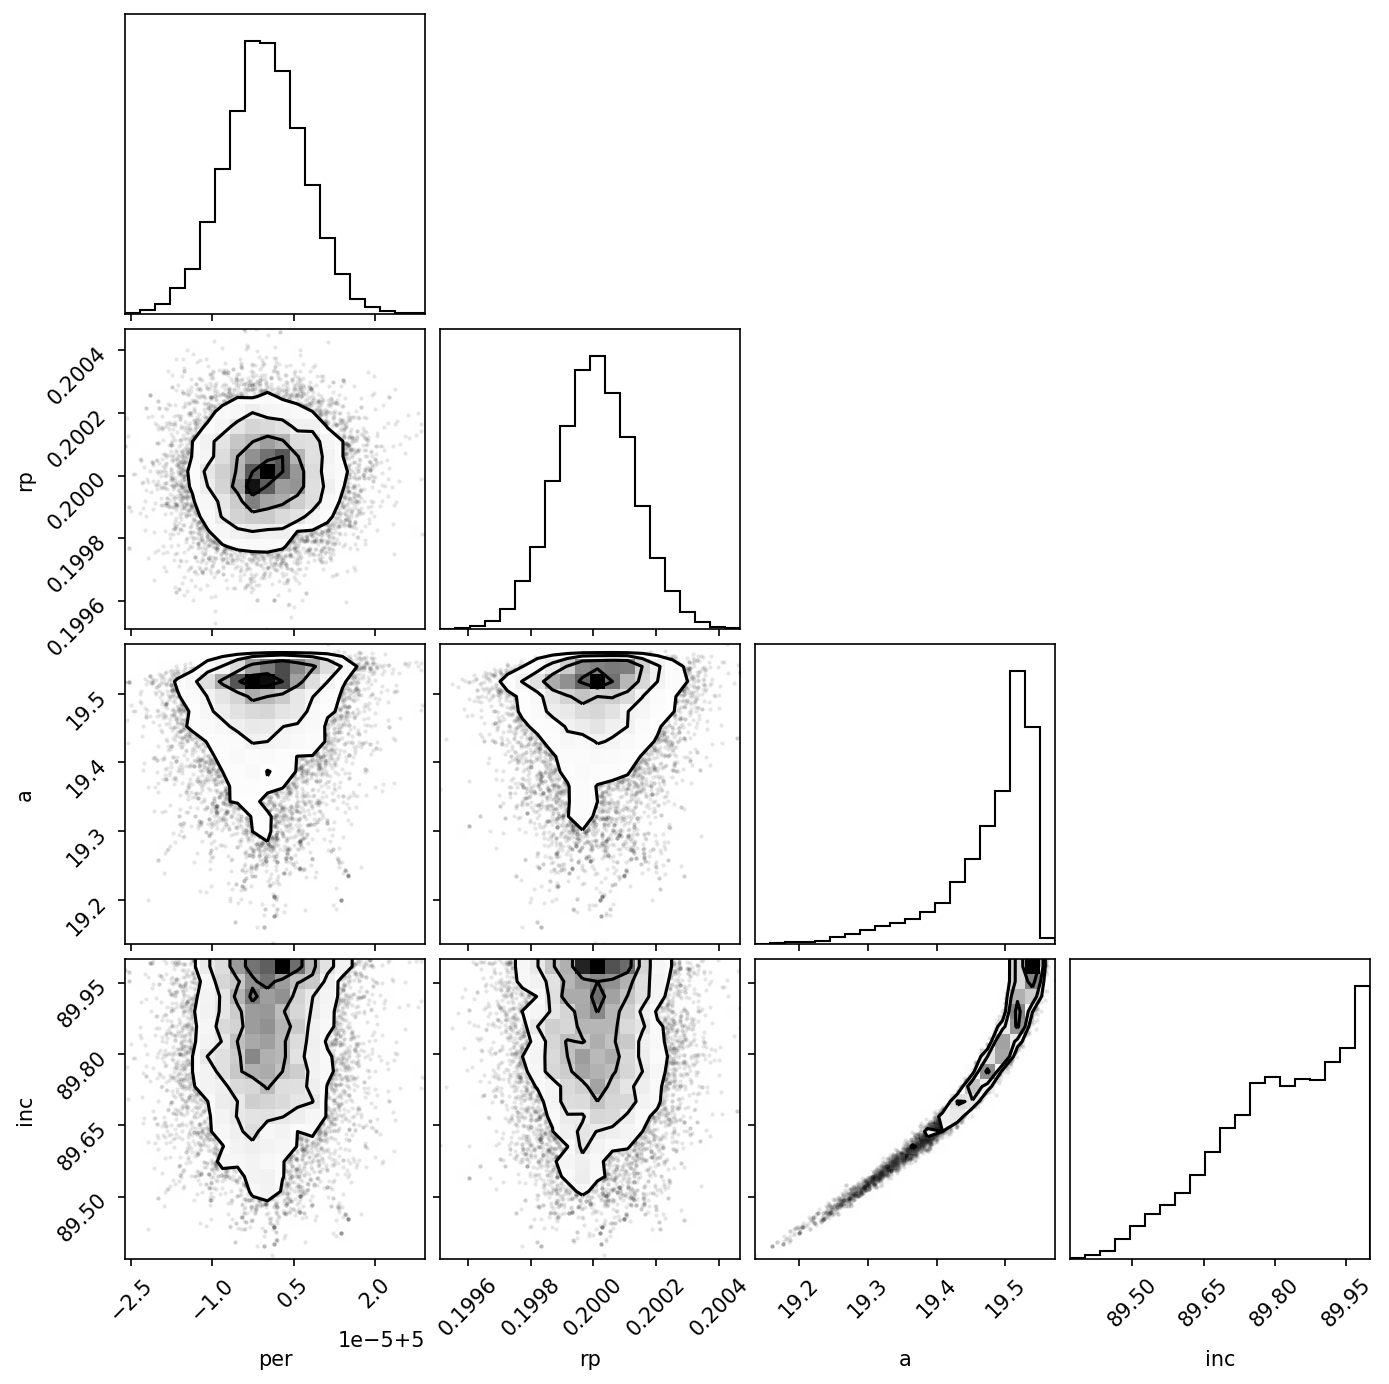

In [39]:
#data = loadtxt('MCMC_samples.csv', delimiter=',')
#flat_samples=data
#log_prob = loadtxt('log_prob_samples.csv', delimiter=',')

labels = ["per", "rp", "a", "inc"]

fig = corner.corner(flat_samples, labels=labels)

In [40]:
period_samples=flat_samples[:,0]
ronr_samples=flat_samples[:,1]
aonr_samples=flat_samples[:,2]
inc_samples=flat_samples[:,3]
likely_set = log_prob
#ecc_samples=flat_samples[:,4]
#omega_samples=flat_samples[:,5]

#Use your array of values for each parameter to determine the likeliest one! See below for a 
#histogram of the guesses for period


Most likely parameter sets in order are:
         Likelihood    Period      RonR       AonR  Inclination
0      70573.801225  5.000000  0.200011  19.531069    89.953794
1      70573.800608  5.000000  0.200007  19.525726    89.915399
2      70573.799916  5.000000  0.200003  19.530636    89.941130
3      70573.796084  4.999999  0.199998  19.531895    89.964993
4      70573.794007  5.000000  0.199985  19.524642    89.913421
5      70573.792399  4.999999  0.200010  19.525146    89.915417
6      70573.792399  4.999999  0.200010  19.525146    89.915417
7      70573.789756  5.000001  0.199987  19.532909    89.971435
8      70573.789095  5.000001  0.200015  19.531351    89.942062
9      70573.788797  5.000001  0.199995  19.528867    89.929521
10661  70571.668024  5.000002  0.200246  19.481504    89.755024

Error bar minimums are:
Likelihood     70571.668024
Period             4.999986
RonR               0.199750
AonR              19.304662
Inclination       89.532370
dtype: float64

Error bar 

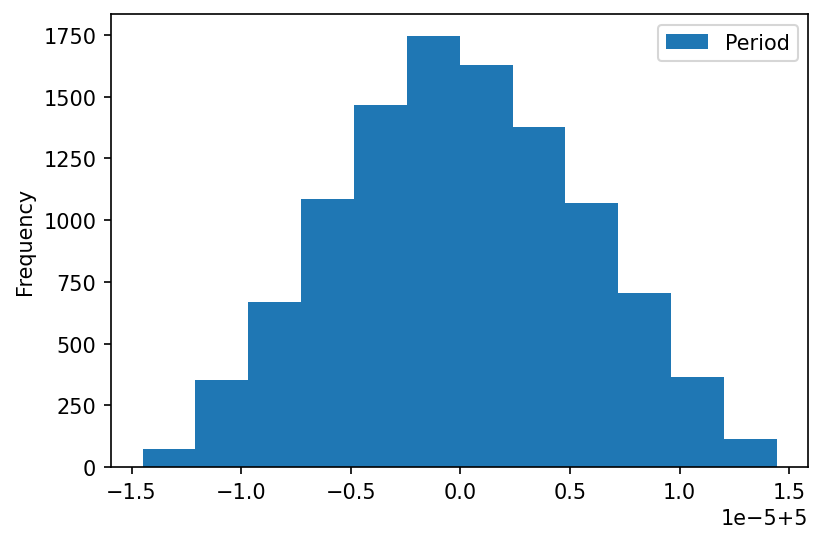

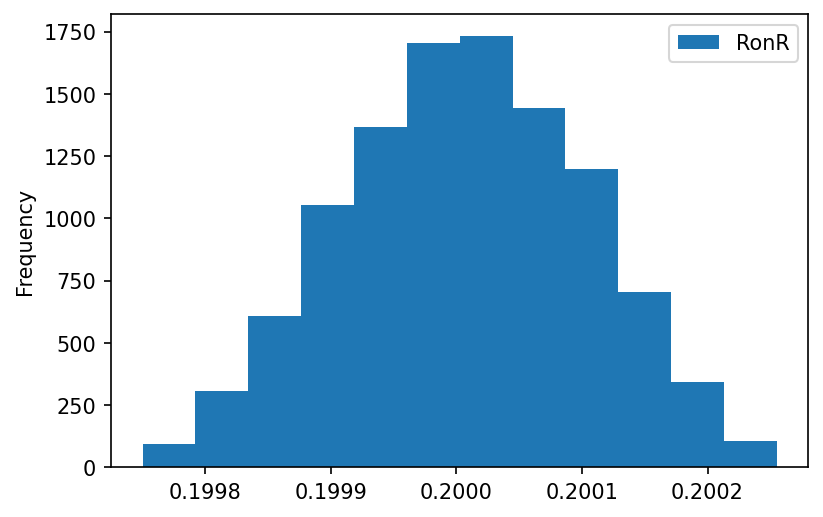

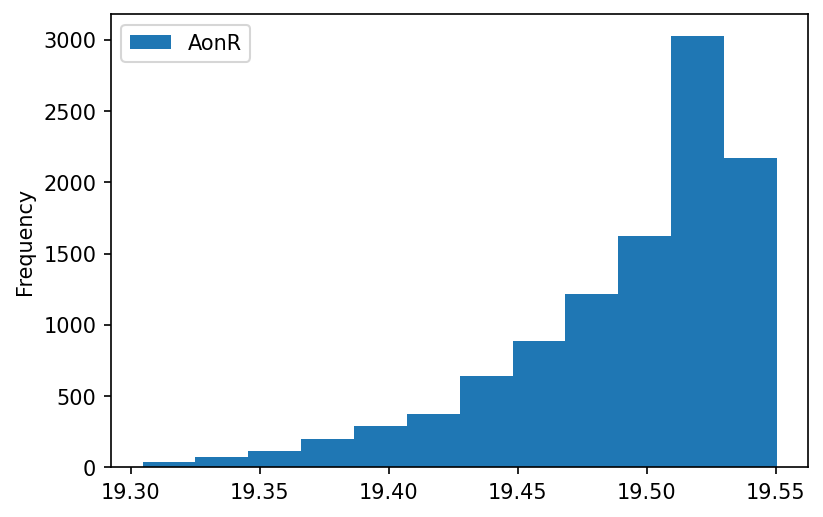

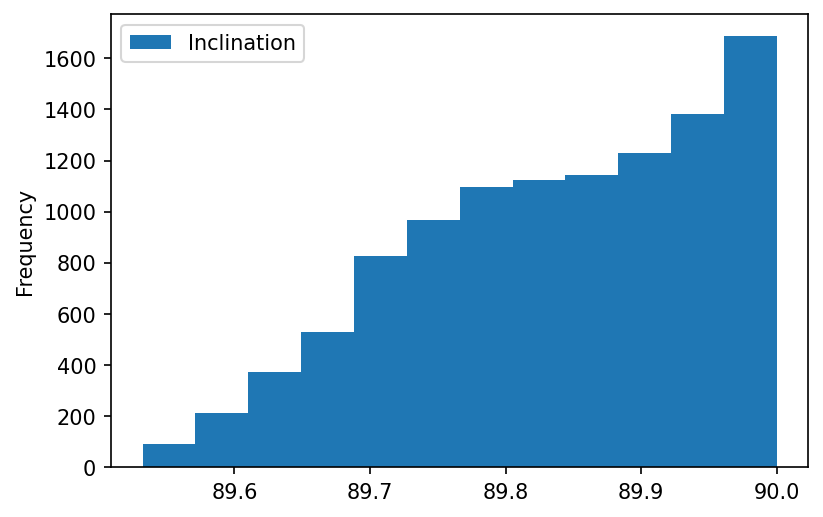

In [41]:
#Getting most likely values within one standard deviation

final_data = pd.DataFrame({'Likelihood' : likely_set, 'Period' : period_samples, 'RonR' : ronr_samples, 'AonR' : aonr_samples, 'Inclination' : inc_samples})
final_data = final_data.sort_values(by=['Likelihood'], ascending=False)
final_data = final_data.reset_index(drop=True)

drops = len(final_data) * .68
final_data = final_data.iloc[0:int(drops), :] #keep only top 68% of answers

best_likelihood = final_data['Likelihood'].idxmin() #min value because the likelihoods are negative for some reason
print('Most likely parameter sets in order are:')
print(final_data.iloc[[0,1,2,3,4,5,6,7,8,9,10661]])
print()
print("Error bar minimums are:")
print(final_data.min())
print()
print("Error bar maximums are:")
print(final_data.max())


period_likeliest_guess = final_data.iloc[0]['Period']
ronr_likeliest_guess = final_data.iloc[0]['RonR']
aonr_likeliest_guess = final_data.iloc[0]['AonR']
inc_likeliest_guess = final_data.iloc[0]['Inclination']

#print(tabulate(final_data, headers='keys', tablefmt='psql')) #table of final data

final_data.plot( y='Period', x='Likelihood', kind='hist', bins=12)
final_data.plot( y='RonR', x='Likelihood', kind='hist', bins=12)
final_data.plot( y='AonR', x='Likelihood', kind='hist', bins=12)
final_data.plot( y='Inclination', x='Likelihood', kind='hist', bins=12)

low_aonr = final_data.sort_values(by=['AonR']) #dataframe organized by AonR
print()
#print(low_aonr)

#final_data.plot.scatter( y='Likelihood', x='Period', s=1) #scatter plot of period values

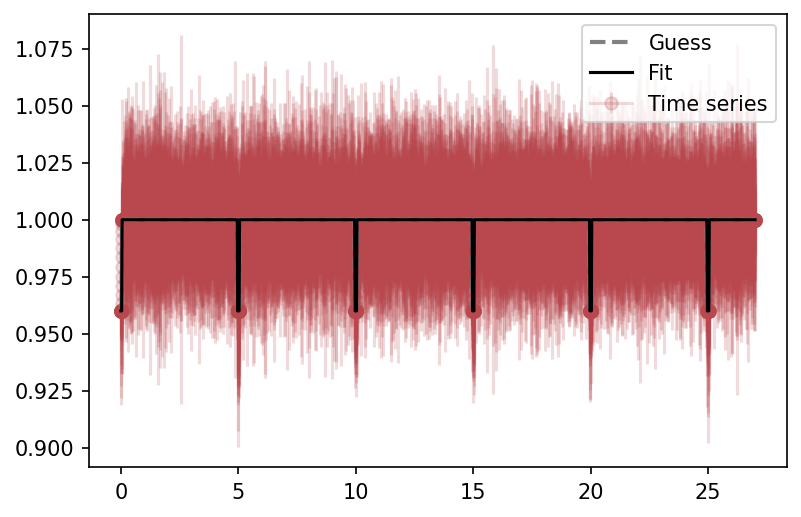

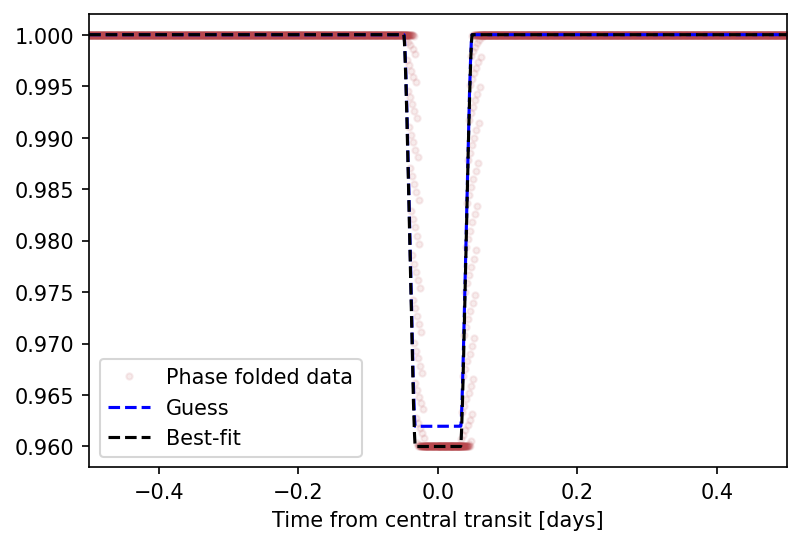

In [42]:
#Extract the likeliest values for your 4 parameters and enter them into this array!
fit=[period_likeliest_guess,ronr_likeliest_guess,aonr_likeliest_guess,inc_likeliest_guess]

#Generating a lightcurve from your guess
flux_guess = model(time, *guess)
plt.plot(time, flux_guess, '--', color='gray', label='Guess', lw=2, zorder=3)

#Generating a lightcurve from your best fit
flux_fit = model(time, *fit )
plt.plot(time, flux_fit, 'k', label='Fit', lw=1.5, zorder=10)

plt.errorbar(time, flux, flux_err,marker="o", color='xkcd:dusty red', label='Time series', alpha=0.2)
plt.legend()
plt.show()


## Phasefold data time-array
phase_fit = (time) % fit[0] / fit[0]
phase_fit[np.where(phase_fit>0.5)] -= 1 
sorted_fit = np.argsort(phase_fit)

## Plot data & model together, phase fold
plt.plot(phase*fit[0], flux, ".", color='xkcd:dusty red', label='Phase folded data', alpha=0.1)
plt.plot(phase[sorted]*guess[0], flux_guess[sorted], '--b', label='Guess')
plt.plot(phase_fit[sorted_fit]*fit[0], flux_fit[sorted_fit], '--k', label='Best-fit')
plt.legend()
plt.xlim(-0.5, 0.5)
plt.xlabel("Time from central transit [days]")
plt.show()

#plt.xlim(4.8, 5.2)
#plt.plot(time, flux)
